In [7]:
from numpy import array
from numpy import argmax
from pickle import load
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# load doc kedalam memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
# load pre-defined list dari photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [4]:
# load clean descriptions kedalam memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line dengan spasi
        tokens = line.split()
        # split id dari description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images yang tidak dalam set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description dalam tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [5]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [6]:
# covert dictionary dari clean descriptions ke list dari descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [7]:
# fit tokenizer yang memberikan caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [8]:
# menghitung panjang description dengan kata terbanyak
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [9]:
# create sequences dari images, input sequences dan output words untuk image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # berjalan melalui setiap image identifier
    for key, desc_list in descriptions.items():
        # berjalan melalui setiap description untuk image
        for desc in desc_list:
            # encode sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence kedalam multiple X,y pairs
            for i in range(1, len(seq)):
                # split kedalam input dan output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [10]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [3]:
# map integer ke word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [5]:
# generate description dari image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict kata selanjutnya
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability ke integer
        yhat = argmax(yhat)
        # map integer ke word
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        # append sebagai input untuk generating kata selanjutnya
        in_text += ' ' + word
        # stop jika sudah berada pada end sequence
        if word == 'endseq':
            break
    return in_text

In [13]:
# evaluate skill dari model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # menghitung BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [4]:
def extract_features(filename):
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [15]:
# train dataset

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [16]:
# dev dataset

# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [17]:
# fit model

# define the model
model = define_model(vocab_size, max_length)

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# fit model
model.fit([X1train, X2train], ytrain, epochs=10, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

C:\Users\kendrick\anaconda3\envs\env_2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 306404 samples, validate on 50903 samples
Epoch 1/10
 - 348s - loss: 4.5027 - val_loss: 4.0509

Epoch 00001: val_loss improved from inf to 4.05090, saving model to model-ep001-loss4.503-val_loss4.051.h5
Epoch 2/10
 - 337s - loss: 3.8388 - val_loss: 3.9092

Epoch 00002: val_loss improved from 4.05090 to 3.90922, saving model to model-ep002-loss3.839-val_loss3.909.h5
Epoch 3/10
 - 339s - loss: 3.6324 - val_loss: 3.8899

Epoch 00003: val_loss improved from 3.90922 to 3.88990, saving model to model-ep003-loss3.632-val_loss3.890.h5
Epoch 4/10
 - 356s - loss: 3.5287 - val_loss: 3.8916

Epoch 00004: val_loss did not improve from 3.88990
Epoch 5/10
 - 347s - loss: 3.4693 - val_loss: 3.9431

Epoch 00005: val_loss did not improve from 3.88990
Epoch 6/10
 - 348s - loss: 3.4354 - val_loss: 3.9218

Epoch 00006: val_loss did not improve from 3.88990
Epoch 7/10
 - 342s - loss: 3.4103 - val_loss: 3.9405

Epoch 00007: val_loss did not improve from 3.88990
Epoch 8/10
 - 350s - loss: 3.3962 - va

In [18]:
# prepare test set
 
# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [22]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.505367
BLEU-2: 0.253885
BLEU-3: 0.179414
BLEU-4: 0.081218


C:\Users\kendrick\anaconda3\envs\env_2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


two dogs are playing in the snow


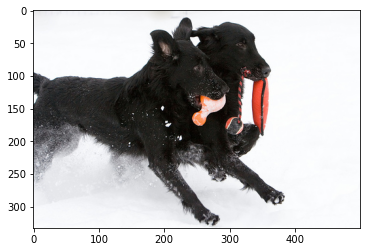

In [10]:
# # load the tokenizer
# tokenizer = load(open('tokenizer.pkl', 'rb'))
# # pre-define the max sequence length (from training)
# max_length = 34
# # load the model
# model = load_model('model-ep003-loss3.632-val_loss3.890.h5')

# load example image
photo = extract_features('example.jpg')
img = mpimg.imread('example.jpg')
plt.imshow(img)

# generate description
description = generate_desc(model, tokenizer, photo, max_length)
description = description.split(' ', 1)[1]
description = description.rsplit(' ', 1)[0] 
print(description)